## Zadanie - klasyczna detekcja obiektów

Celem tego zadania jest własnoręczne zbudowanie, debugowanie i przetestowanie przez Ciebie prostego pipeline'u do rozpoznawania obiektów opartego o klasyczne metody przetwarzania obrazów.

In [1]:
from skimage.feature import peak_local_max
from matplotlib.patches import Patch
from typing import List, Tuple, Any
from dataclasses import dataclass
import matplotlib.pyplot as plt
from enum import Enum
from tqdm import tqdm
import numpy as np
import cv2
import time

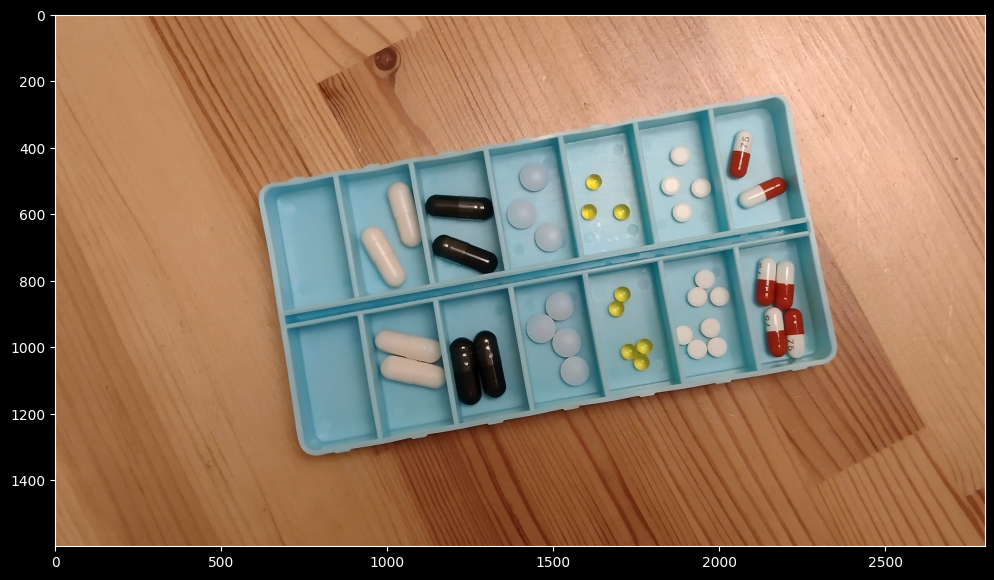

In [2]:
calib = cv2.imread('dane5/calib.png')
plt.subplots(1, 1, figsize=(12,8))[1].imshow(calib[..., ::-1]);

In [3]:
def rhotheta2xy(line):
    # konwersja parametrów prostej w układzie rho-theta do odcinka w układzie kartezjańskim
    # wynik można użyć jako argumenty funkcji cv2.line
    rho, theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 5000*(-b))
    y1 = int(y0 + 5000*(a))
    x2 = int(x0 - 5000*(-b))
    y2 = int(y0 - 5000*(a))
    return x1, y1, x2, y2

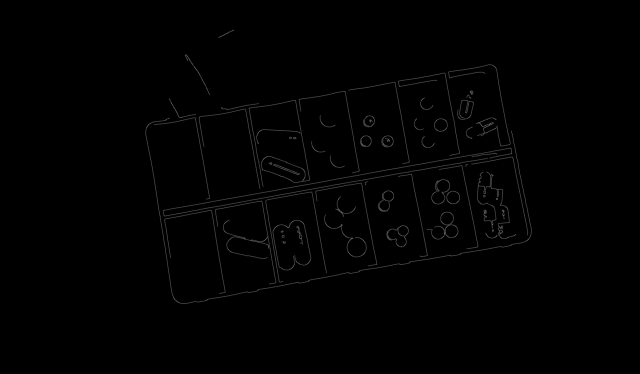

In [4]:
filtered_calib = cv2.GaussianBlur(calib, (11, 11), 0)

calib_edges = cv2.Canny(filtered_calib, 50, 150)

plt.figure(figsize=(8,8))
plt.imshow(calib_edges, cmap='gray')
plt.axis('off')
plt.show()

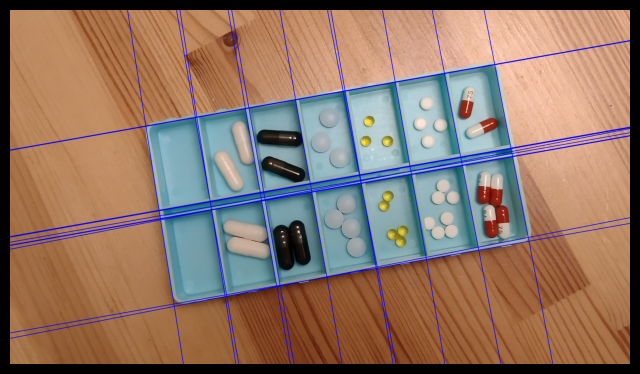

In [5]:
rho_pillbox = 1
theta_pillbox = np.pi / 180
threshold_pillbox = 200

lines_pillbox = cv2.HoughLines(calib_edges, rho_pillbox, theta_pillbox, threshold_pillbox)

pillbox_with_lines = calib.copy()

for line in lines_pillbox:
    x1, y1, x2, y2 = rhotheta2xy(line)
    cv2.line(pillbox_with_lines, (x1, y1), (x2, y2), (255, 0, 0), 2)

plt.figure(figsize=(8,8))
plt.imshow(pillbox_with_lines[..., ::-1])
plt.axis('off')
plt.show()

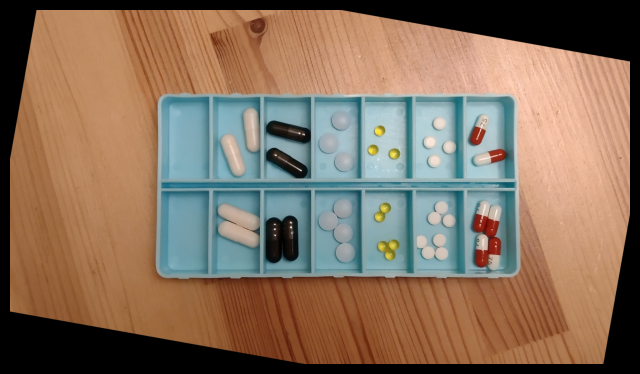

In [6]:
def get_rotation_angle(lines):
    angles = []
    for line in lines:
        rho, theta = line[0]
        # Convert theta to degrees
        angle = theta * 180 / np.pi
        # We're interested in horizontal lines (angles near 0 or 180)
        if angle < 45 or angle > 135:
            angles.append(angle)

    # Get the average angle
    mean_angle = np.mean(angles)
    if mean_angle > 90:
        return mean_angle - 180
    
    return mean_angle

# Get the rotation angle
angle = get_rotation_angle(lines_pillbox)

# Rotate the image
height, width = calib.shape[:2]
center = (width/2, height/2)
rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
rotated_image = cv2.warpAffine(calib, rotation_matrix, (width, height))

plt.figure(figsize=(8, 8))
plt.imshow(rotated_image[..., ::-1])
plt.axis('off')
plt.show()

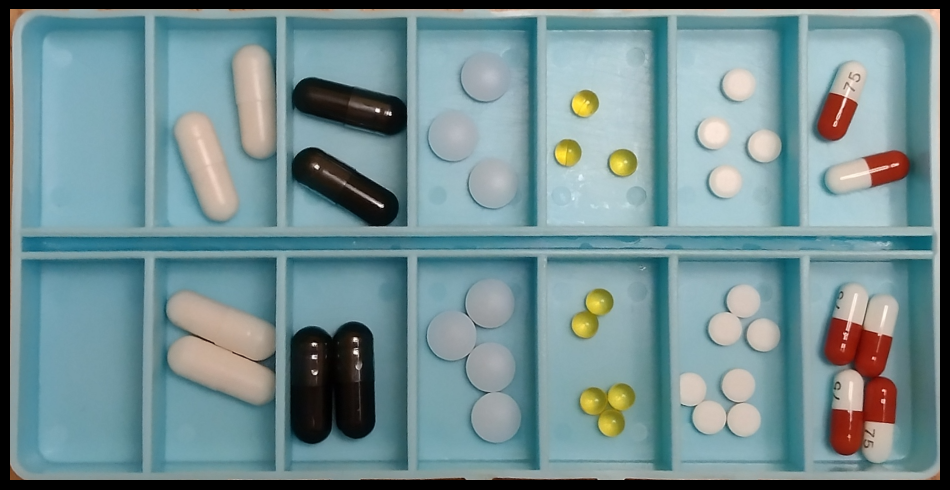

In [7]:
# After rotation, let's improve the pillbox detection and cropping
rotated_gray = cv2.cvtColor(rotated_image, cv2.COLOR_BGR2GRAY)

# Let's try using color to detect the blue box instead
hsv = cv2.cvtColor(rotated_image, cv2.COLOR_BGR2HSV)
# Blue color range in HSV
lower_blue = np.array([90,50,50])
upper_blue = np.array([130,255,255])
blue_mask = cv2.inRange(hsv, lower_blue, upper_blue)

# Clean up the mask
kernel = np.ones((5,5), np.uint8)
blue_mask = cv2.morphologyEx(blue_mask, cv2.MORPH_CLOSE, kernel)
blue_mask = cv2.morphologyEx(blue_mask, cv2.MORPH_OPEN, kernel)

# Find contours of the pillbox
contours, _ = cv2.findContours(blue_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
pillbox_contour = max(contours, key=cv2.contourArea)

# Get a tighter bounding rect
x, y, w, h = cv2.boundingRect(pillbox_contour)

# Add a small padding to avoid cutting pills
padding = 10
x = max(0, x - padding)
y = max(0, y - padding)
w = min(rotated_image.shape[1] - x, w + 2*padding)
h = min(rotated_image.shape[0] - y, h + 2*padding)

# Crop the pillbox
calib_cropped = rotated_image[y:y+h, x:x+w]

# Debug visualization
plt.figure(figsize=(12,8))
plt.imshow(cv2.cvtColor(calib_cropped, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [8]:
def crop_image(path):

    calib = cv2.imread(path)

    filtered_calib = cv2.GaussianBlur(calib, (11, 11), 0)
    calib_edges = cv2.Canny(filtered_calib, 50, 150)

    rho_pillbox = 1
    theta_pillbox = np.pi / 180
    threshold_pillbox = 200

    lines_pillbox = cv2.HoughLines(calib_edges, rho_pillbox, theta_pillbox, threshold_pillbox)

    pillbox_with_lines = calib.copy()

    for line in lines_pillbox:
        x1, y1, x2, y2 = rhotheta2xy(line)  
        cv2.line(pillbox_with_lines, (x1, y1), (x2, y2), (255, 0, 0), 2)


    angle = get_rotation_angle(lines_pillbox)

    # Rotate the image
    height, width = calib.shape[:2]
    center = (width/2, height/2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_image = cv2.warpAffine(calib, rotation_matrix, (width, height))


    hsv = cv2.cvtColor(rotated_image, cv2.COLOR_BGR2HSV)

    lower_blue = np.array([90,50,50])
    upper_blue = np.array([130,255,255])
    blue_mask = cv2.inRange(hsv, lower_blue, upper_blue)

    kernel = np.ones((5,5), np.uint8)
    blue_mask = cv2.morphologyEx(blue_mask, cv2.MORPH_CLOSE, kernel)
    blue_mask = cv2.morphologyEx(blue_mask, cv2.MORPH_OPEN, kernel)

    contours, _ = cv2.findContours(blue_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    pillbox_contour = max(contours, key=cv2.contourArea)

    x, y, w, h = cv2.boundingRect(pillbox_contour)

    padding = 10
    x = max(0, x - padding)
    y = max(0, y - padding)
    w = min(rotated_image.shape[1] - x, w + 2*padding)
    h = min(rotated_image.shape[0] - y, h + 2*padding)

    calib_cropped = rotated_image[y:y+h, x:x+w]
    return calib_cropped

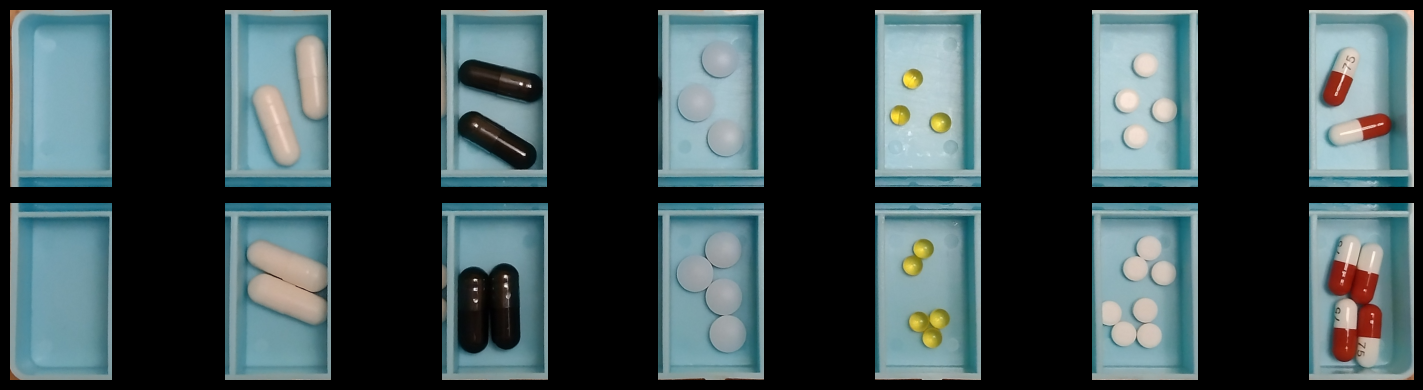

In [9]:
def get_cells_of_pillbox(image, padding=10):
    if len(image.shape) == 2:
        h, w = image.shape
    # Otherwise, assume it's a 3-channel color image
    else:
        h, w, _ = image.shape

    # Divide the image into 2 rows and 7 columns
    cell_height = h // 2
    cell_width = w // 7
    
    cells = []
    for row in range(2):
        for col in range(7):
            x1 = max(0, col * cell_width - padding)
            y1 = max(0, row * cell_height - padding)
            x2 = min(w, (col + 1) * cell_width + padding)
            y2 = min(h, (row + 1) * cell_height + padding)
            cell = image[y1:y2, x1:x2]
            cells.append(cell)
    
    return cells

cells = get_cells_of_pillbox(calib_cropped)

# Display the cells in a 2x7 subplot
fig, axes = plt.subplots(2, 7, figsize=(16, 4))
for i, cell in enumerate(cells):
    row = i // 7
    col = i % 7
    axes[row, col].imshow(cv2.cvtColor(cell, cv2.COLOR_BGR2RGB))
    axes[row, col].axis('off')
plt.tight_layout()
plt.show()

In [10]:
def display_image_and_histogram_hsv(image,  figsize=(12,4)):
  image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
  h, s, v = cv2.split(image_hsv)

  fig, axs = plt.subplots(2, 3, figsize=figsize)
  axs[0, 0].imshow(h, cmap='gray')
  axs[0, 0].set_title('Hue')
  axs[0, 0].axis('off')
  axs[0, 1].imshow(s, cmap='gray')
  axs[0, 1].set_title('Saturation')
  axs[0, 1].axis('off')
  axs[0, 2].imshow(v, cmap='gray')
  axs[0, 2].set_title('Value')
  axs[0, 2].axis('off')
  axs[1, 0].hist(h.ravel(), bins=256, color='gray')
  axs[1, 1].hist(s.ravel(), bins=256, color='gray')
  axs[1, 2].hist(v.ravel(), bins=256, color='gray')
  plt.tight_layout()
  plt.show()

  return image_hsv

In [11]:
def display_image_and_histogram_lab(image,  figsize=(12,4)):
  image_lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
  h, s, v = cv2.split(image_lab)

  fig, axs = plt.subplots(2, 3, figsize=figsize)
  axs[0, 0].imshow(h, cmap='gray')
  axs[0, 0].set_title('L')
  axs[0, 0].axis('off')
  axs[0, 1].imshow(s, cmap='gray')
  axs[0, 1].set_title('a')
  axs[0, 1].axis('off')
  axs[0, 2].imshow(v, cmap='gray')
  axs[0, 2].set_title('b')
  axs[0, 2].axis('off')
  axs[1, 0].hist(h.ravel(), bins=256, color='gray')
  axs[1, 1].hist(s.ravel(), bins=256, color='gray')
  axs[1, 2].hist(v.ravel(), bins=256, color='gray')
  plt.tight_layout()
  plt.show()

  return image_lab

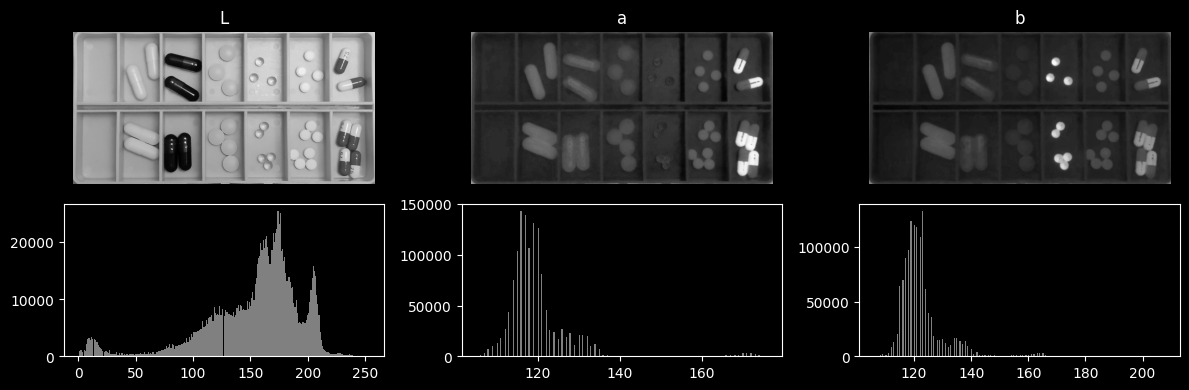

In [12]:
lab = display_image_and_histogram_lab(calib_cropped)

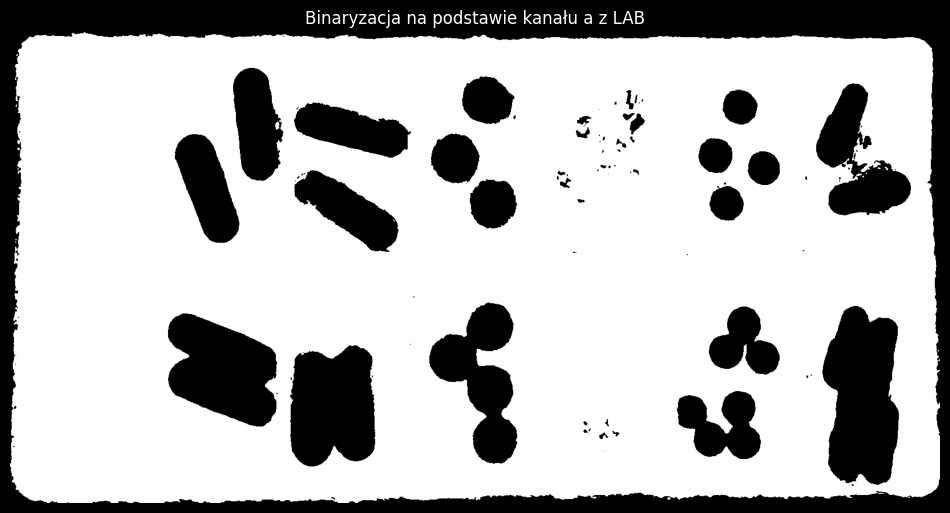

In [13]:
l, a, b = cv2.split(lab)

a_blurred = cv2.GaussianBlur(a, (5,5), 0)

_, a_binary = cv2.threshold(a_blurred, 122, 255, cv2.THRESH_BINARY_INV)

plt.figure(figsize=(12,8))
plt.imshow(a_binary, cmap='gray')
plt.title('Binaryzacja na podstawie kanału a z LAB')
plt.axis('off')
plt.show()

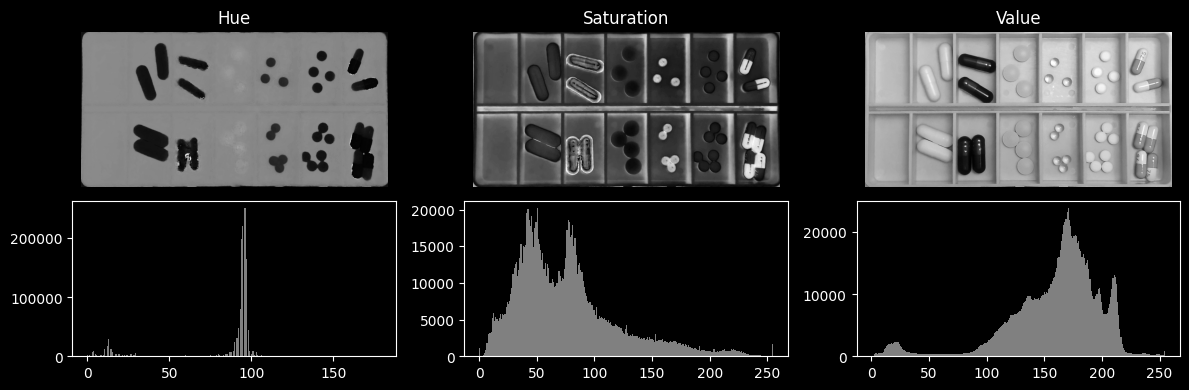

In [14]:
hsv = display_image_and_histogram_hsv(calib_cropped)

In [15]:
h, s, v = cv2.split(hsv)

h_blurred = cv2.GaussianBlur(h, (5,5), 0)

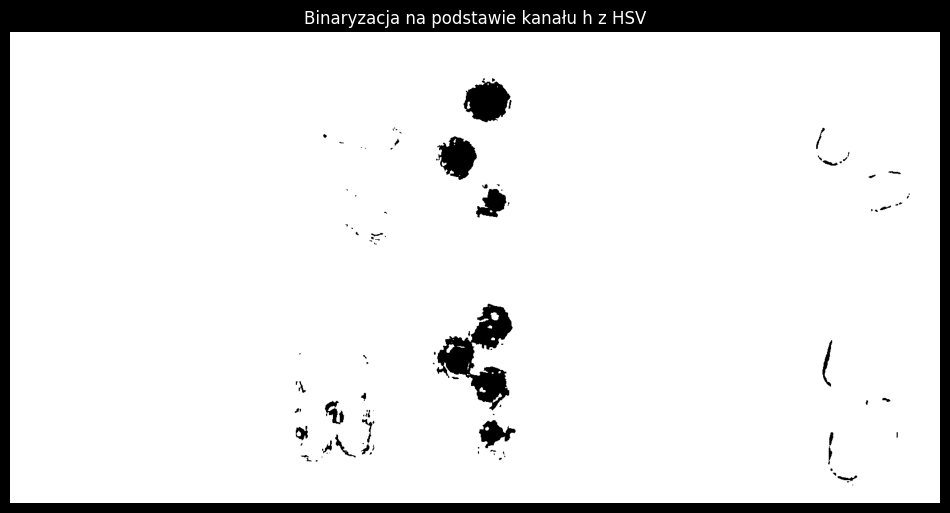

In [16]:
_, h_binary = cv2.threshold(h_blurred, 100, 255, cv2.THRESH_BINARY_INV)

plt.figure(figsize=(12,8))
plt.imshow(h_binary, cmap='gray')
plt.title('Binaryzacja na podstawie kanału h z HSV')
plt.axis('off')
plt.show()

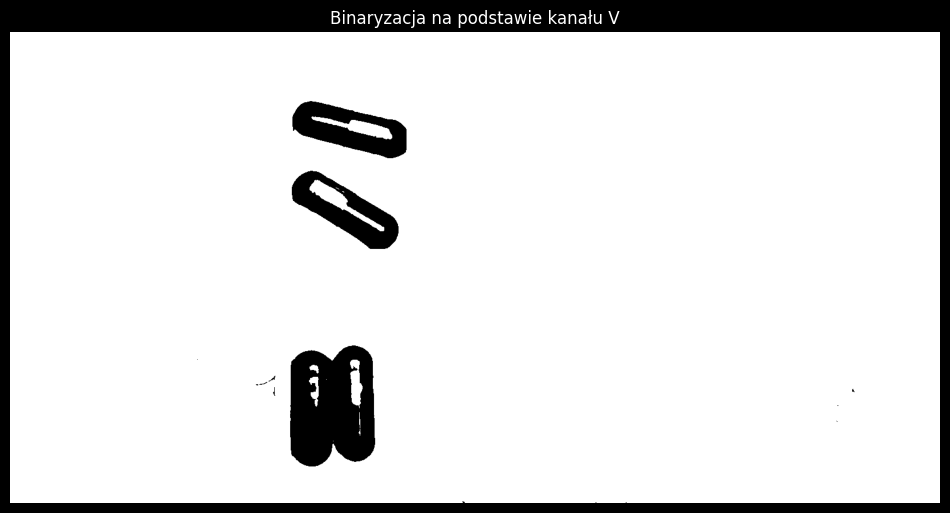

In [17]:
v_blurred = cv2.GaussianBlur(v, (5,5), 0)
threshold = 50
_, v_binary = cv2.threshold(v_blurred, threshold, 255, cv2.THRESH_BINARY)

plt.figure(figsize=(12,8))
plt.imshow(v_binary, cmap='gray')
plt.title('Binaryzacja na podstawie kanału V')
plt.axis('off')
plt.show()

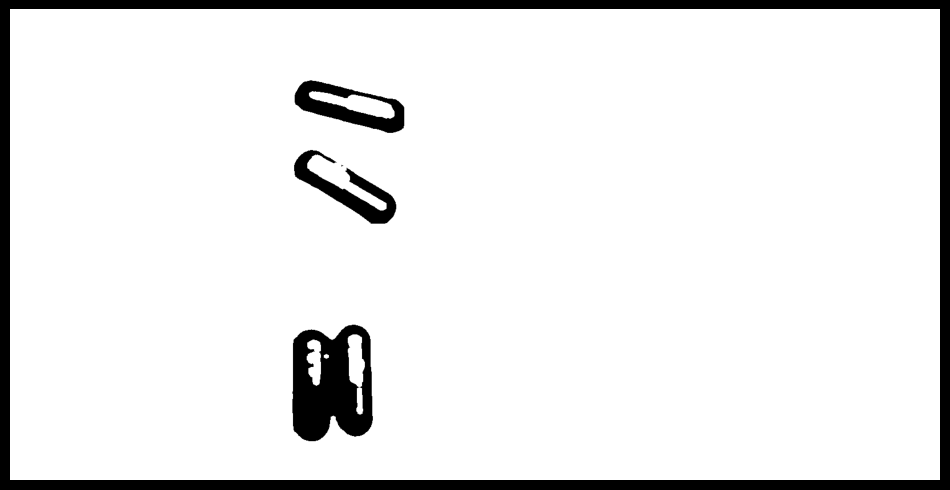

In [18]:
# distilation
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))

v_binary_eroded = cv2.morphologyEx(v_binary, cv2.MORPH_DILATE, kernel, iterations=2)

plt.figure(figsize=(12,8))
plt.imshow(v_binary_eroded, cmap='gray')
plt.axis('off')
plt.show()


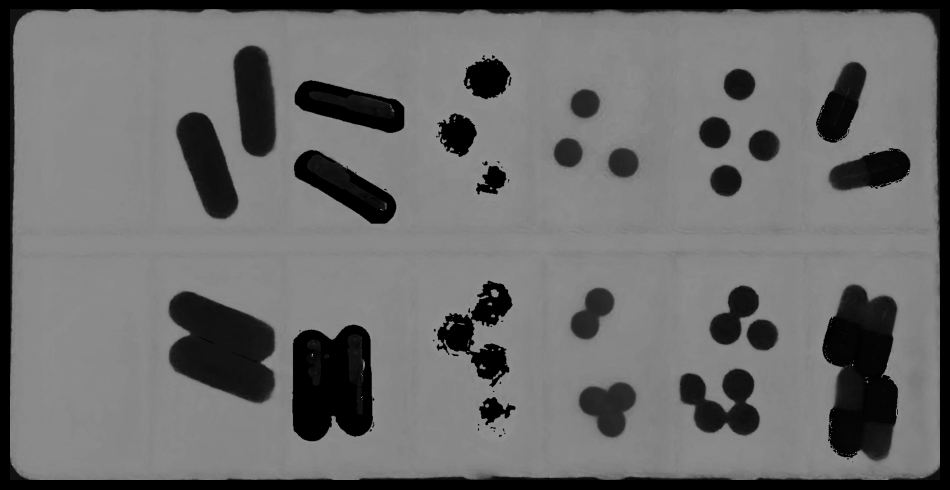

In [19]:
# add black parts of h_binary to h_blurred
h[h_binary == 0] = 0
h[v_binary_eroded == 0] = 0

plt.figure(figsize=(12,8))
plt.imshow(h, cmap='gray')
plt.axis('off')
plt.show()

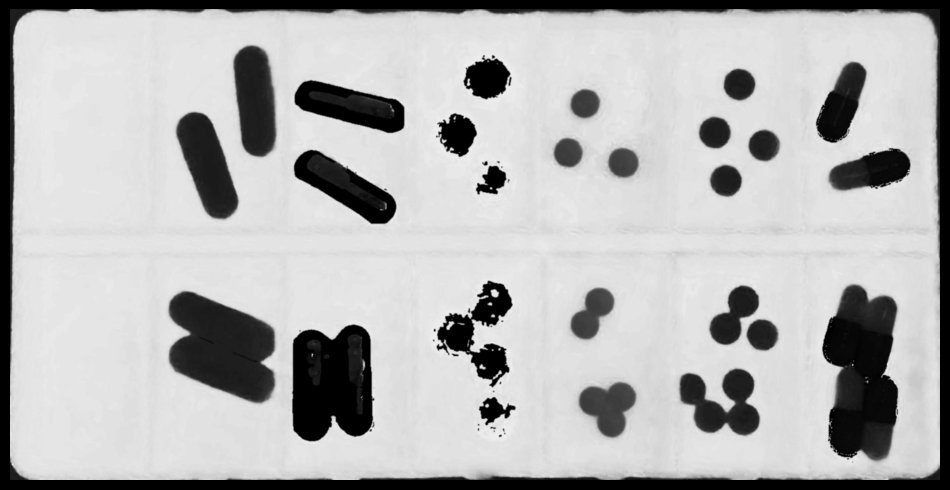

In [20]:
h_blurred = cv2.GaussianBlur(h, (3,3), 0)

plt.figure(figsize=(12,8))
plt.imshow(h_blurred, cmap='gray')
plt.axis('off')
plt.show()

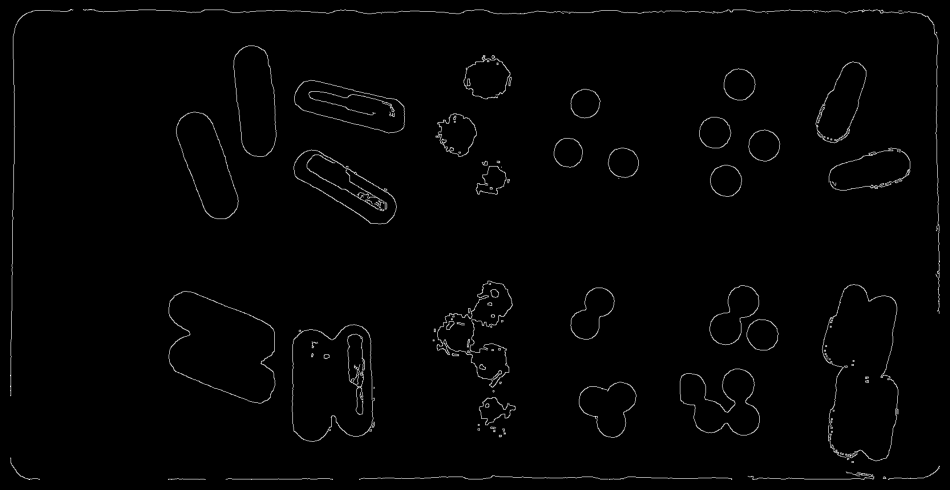

In [21]:
canny = cv2.Canny(h_blurred, 5, 70)

plt.figure(figsize=(12,8))
plt.imshow(canny, cmap='gray')
plt.axis('off')
plt.show()

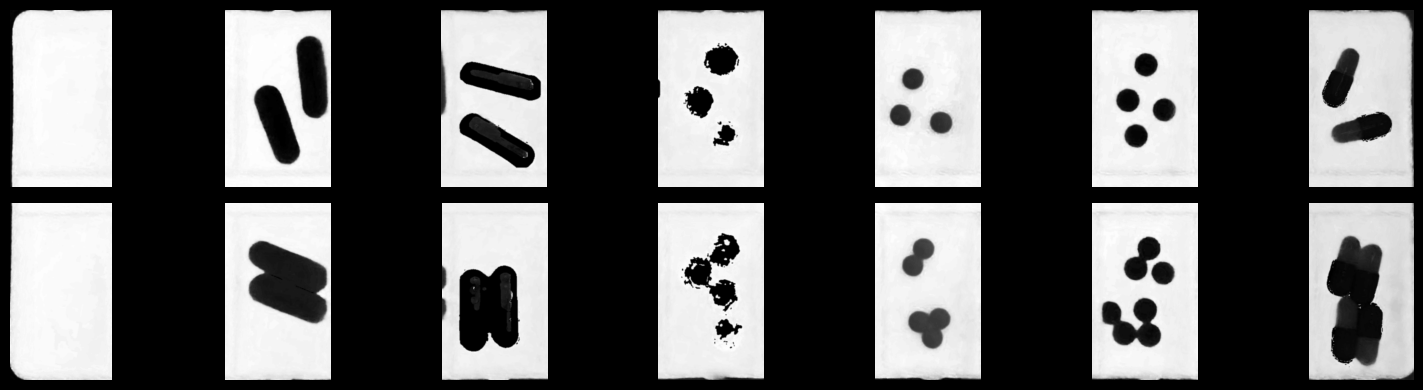

In [22]:
cells = get_cells_of_pillbox(h_blurred)

# Display the cells in a 2x7 subplot
fig, axes = plt.subplots(2, 7, figsize=(16, 4))
for i, cell in enumerate(cells):
    row = i // 7
    col = i % 7
    axes[row, col].imshow(cell, cmap='gray')
    axes[row, col].axis('off')
plt.tight_layout()
plt.show()

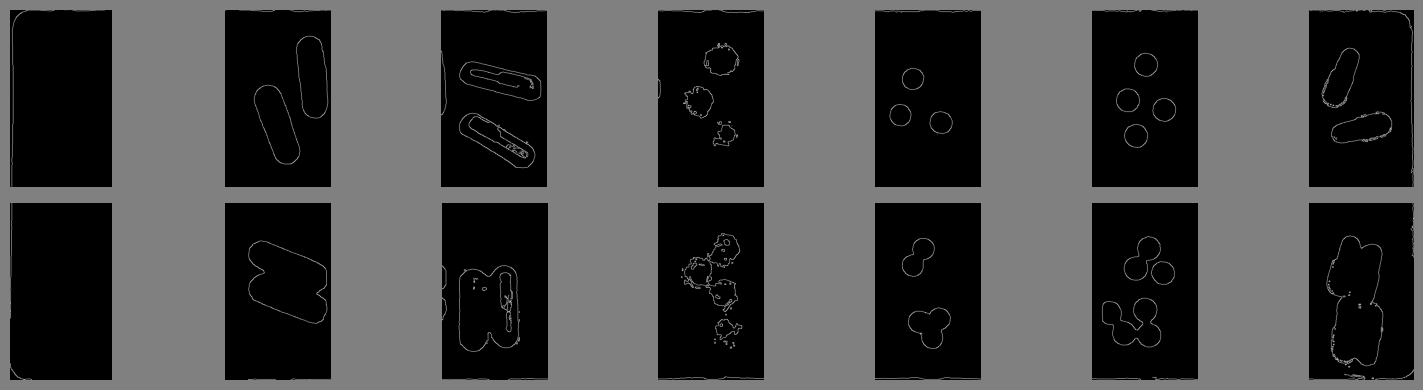

In [23]:
cells = get_cells_of_pillbox(canny)

# Display the cells in a 2x7 subplot
fig, axes = plt.subplots(2, 7, figsize=(16, 4), facecolor='gray')
for i, cell in enumerate(cells):
    row = i // 7
    col = i % 7
    axes[row, col].imshow(cell, cmap='gray')
    axes[row, col].axis('off')
plt.tight_layout()
plt.show()

In [24]:
class PillType(Enum):
    PROBIO = 1    # duże białe kapsułki
    CARBON = 2    # duże czarne kapsułki
    KETO = 3      # niebieskie tabletki
    ESPU = 4      # małe żółte kapsułki
    BIOX = 5      # małe białe tabletki
    LINE = 6      # czerwono-białe kapsułki (klasa trudna - realizacja opcjonalna)


COLORMAP = {
    PillType.PROBIO: (0, 0, 0),           # Białe
    PillType.CARBON: (255, 255, 255),     # Czarne
    PillType.KETO: (255, 0, 0),           # Niebieskie (BGR)
    PillType.ESPU: (0, 255, 255),         # Żółte (BGR)
    PillType.BIOX: (255, 0, 255),         # Małe białe (BGR)
    PillType.LINE: (0, 0, 255),           # Czerwone (BGR)
}

@dataclass
class Pill:
    type: PillType
    is_capsule: bool = False
    center_x: int = None
    center_y: int = None
    radius: int = 0
    length: float = None
    width: float = None 
    angle: float = None 

In [26]:


def preprocess_image(compartment_image: np.ndarray, debug: bool = False) -> Tuple[np.ndarray]:
    hsv = cv2.cvtColor(compartment_image, cv2.COLOR_BGR2HSV)

    h_channel, s_channel, v_channel = cv2.split(hsv)
    h_blurred = cv2.GaussianBlur(h_channel, (5, 5), 0)
    _, h_binary = cv2.threshold(h_blurred, 100, 255, cv2.THRESH_BINARY_INV)
    h_channel[h_binary == 0] = 0

    v_blurred = cv2.GaussianBlur(v_channel, (5, 5), 0)
    _, v_binary = cv2.threshold(v_blurred, 50, 255, cv2.THRESH_BINARY)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    v_binary_eroded = cv2.morphologyEx(v_binary, cv2.MORPH_DILATE, kernel, iterations=2)
    h_channel[v_binary_eroded == 0] = 0
    
    h_blurred = cv2.GaussianBlur(h_channel, (3, 3), 0)
    edges = cv2.Canny(h_blurred, 5, 70)

    return h_blurred, edges, hsv

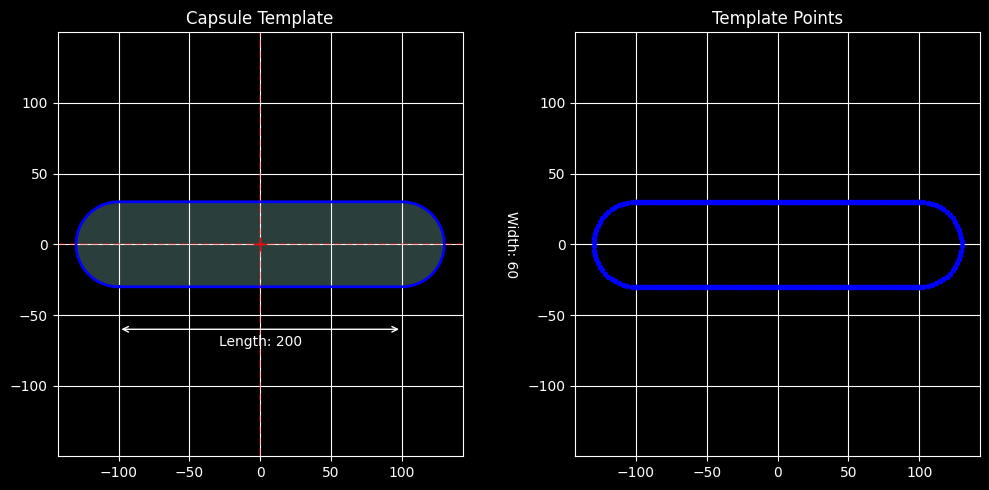

In [27]:
def generate_capsule_points(length: float, width: float, num_points: int = 64) -> np.ndarray:
    points = []
    radius = width / 2
    
    straight_points = 100  # Number of points along straight edges
    
    angles_end = np.linspace(-np.pi/2, np.pi/2, num_points//2)
    angles_transition = np.linspace(-np.pi/4, np.pi/4, num_points//4)  # More points at transition
    
    for i in range(straight_points):
        t = i / (straight_points - 1)
        points.append([t * length - length/2, -radius])
    
    for angle in angles_end:
        x = length/2 + radius * np.cos(angle)
        y = radius * np.sin(angle)
        points.append([x, y])
        
    for i in range(straight_points):
        t = i / (straight_points - 1)
        points.append([t * length - length/2, radius])
    
    for angle in angles_end:
        x = -length/2 - radius * np.cos(angle)
        y = -radius * np.sin(angle)
        points.append([x, y])
    
    return np.array(points)

def visualize_capsule_template(length: float, width: float, num_points: int = 32) -> None:
    
    points = generate_capsule_points(length, width, num_points)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.plot(points[:, 0], points[:, 1], 'b-', linewidth=2)
    plt.fill(points[:, 0], points[:, 1], alpha=0.3)
    plt.grid(True)
    plt.axis('equal')
    plt.title('Capsule Template')
    
    plt.plot(0, 0, 'r+', markersize=10)
    plt.axhline(y=0, color='r', linestyle='--', alpha=0.3)
    plt.axvline(x=0, color='r', linestyle='--', alpha=0.3)
    
    plt.annotate('', xy=(length/2, -width), xytext=(-length/2, -width),
                arrowprops=dict(arrowstyle='<->'))
    plt.text(0, -width*1.2, f'Length: {length}', ha='center')
    
    plt.annotate('', xy=(length/2 + width, width/2), xytext=(length/2 + width, -width/2),
                arrowprops=dict(arrowstyle='<->'))
    plt.text(length/2 + width*1.2, 0, f'Width: {width}', va='center', rotation=-90)
    
    plt.subplot(122)
    plt.plot(points[:, 0], points[:, 1], 'b.-', linewidth=0)
    plt.grid(True)
    plt.axis('equal')
    plt.title('Template Points')
    
    plt.tight_layout()
    plt.show()
    
    return points

points = visualize_capsule_template(200, 60, 64)

In [28]:
def analyze_capsule_colors(image: np.ndarray, cx: float, cy: float, length: float, width: float, angle: float) -> tuple:
    angle_rad = np.radians(angle)
    
    # Calculate end points
    half_length = length / 2
    dx = half_length * np.cos(angle_rad)
    dy = half_length * np.sin(angle_rad)
    
    # Get coordinates for both ends
    left_x = int(cx - dx)
    left_y = int(cy - dy)
    right_x = int(cx + dx)
    right_y = int(cy + dy)
    
    # Create small circular masks 
    radius = int(width)
    sample_radius = int(radius*3/5)  # Use smaller radius for sampling
    
    # Create masks for both ends
    y, x = np.ogrid[:image.shape[0], :image.shape[1]]
    left_mask = ((x - left_x)**2 + (y - left_y)**2 <= sample_radius**2)
    right_mask = ((x - right_x)**2 + (y - right_y)**2 <= sample_radius**2)
    center_mask = ((x - cx)**2 + (y - cy)**2 <= sample_radius**2)
    

    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # Calculate mean HSV values for both ends
    left_hsv = cv2.mean(hsv, mask=left_mask.astype(np.uint8))[:3]
    right_hsv = cv2.mean(hsv, mask=right_mask.astype(np.uint8))[:3]
    center_hsv = cv2.mean(hsv, mask=center_mask.astype(np.uint8))[:3]
    
    return left_hsv, right_hsv, center_hsv


def classify_pill_color(left_hsv: tuple, right_hsv: tuple, center_hsv: tuple):

    def is_black(hsv):
        _, _, v = hsv
        return v < 80
    
    def is_white(hsv, h_thresh=40):
        h, _, v = hsv
        return h < h_thresh and v > 100
    
    def is_red(hsv):
        h, s, _ = hsv
        return ((0 <= h <= 50) or (150 <= h <= 200)) and s > 100
    
    if is_black(left_hsv) and is_black(right_hsv) and is_black(center_hsv):
        return PillType.CARBON
    
    elif (is_white(left_hsv, h_thresh=50) and is_red(right_hsv)) or (is_red(left_hsv) and is_white(right_hsv, h_thresh=50)):
        return PillType.LINE
    
    elif is_white(left_hsv) and is_white(right_hsv) and is_white(center_hsv):
        return PillType.PROBIO
    
    else:
        return 'unknown'

In [29]:
def non_max_suppression(
    capsules: List[Tuple],
    image: np.ndarray,
    angle_thresh: float = 15.0,
) -> List[Pill]:
    
    if not capsules:
        return []
    
    # Sort capsules by score
    capsules = sorted(capsules, key=lambda x: x[5], reverse=True)
    kept_capsules = []
    final_kept_capsules = []
    
    # Remove border detections
    border_margin = 20
    height, width = image.shape[:2]
    
    for capsule in capsules:
        cx1, cy1, l1, w1, a1, score = capsule
        
        # Skip border detections
        if (cx1 < border_margin or cx1 > width - border_margin or 
            cy1 < border_margin or cy1 > height - border_margin):
            continue
        
        left_hsv, right_hsv, center_hsv = analyze_capsule_colors(image, cx1, cy1, l1, w1, a1)
        color_type = classify_pill_color(left_hsv, right_hsv, center_hsv)
        if color_type == 'unknown':
            continue

        # Non-max suppression
        overlaps = False
        for kept_capsule in kept_capsules:
            cx2, cy2, l2, w2, a2, score = kept_capsule

            left_hsv2, right_hsv2, center_hsv2 = analyze_capsule_colors(image, cx2, cy2, l2, w2, a2)
            color_type2 = classify_pill_color(left_hsv2, right_hsv2, center_hsv2)
            
            dist = np.sqrt((cx1-cx2)**2 + (cy1-cy2)**2)
            
            angle_diff = min(abs(a1-a2), 180-abs(a1-a2))
            
            # Dynamic distance threshold based on pill size
            avg_length = (l1 + l2) / 2
            
            len_thresh = 0.8 
            if color_type == color_type2 == PillType.LINE:
                len_thresh = 0.6
            dist_threshold = avg_length * len_thresh
            
            if dist < dist_threshold and angle_diff < angle_thresh:
                overlaps = True
                break
        
        if not overlaps:
            final_kept_capsules.append(Pill(type=color_type, is_capsule=True, center_x=cx1, center_y=cy1, radius=w1//2, length=l1, width=w1, angle=a1))
            kept_capsules.append(capsule)
    
    return final_kept_capsules

In [30]:
def detect_capsules(compartment_image, edges, debug=False):
    
    angles = np.arange(0, 180, 5)
    lengths = np.arange(100, 130, 10)
    widths = np.arange(60, 70, 15)
    
    y_coords, x_coords = np.nonzero(edges)
    edge_points = np.column_stack((x_coords, y_coords))
    
    if len(edge_points) == 0:
        print("No edge points detected!")
        return []
    
    max_votes = 0
    capsules = []
    
    total_iterations = len(angles) * len(lengths) * len(widths)
    with tqdm(total=total_iterations, desc="Detecting capsules") as pbar:
        for angle in angles:
            angle_rad = np.radians(angle)
            rot_matrix = np.array([[np.cos(angle_rad), -np.sin(angle_rad)],
                                 [np.sin(angle_rad), np.cos(angle_rad)]])
            
            for length in lengths:
                for width in widths:

                    template_points = generate_capsule_points(length, width)
                    rotated_template = np.dot(template_points, rot_matrix.T)
                    
                    votes = np.zeros(compartment_image.shape[:2], dtype=np.float32)
                    
                    for edge_point in edge_points:
                        translated = rotated_template + edge_point
                        
                        valid_idx = (
                            (translated[:, 0] >= 0) & 
                            (translated[:, 0] < compartment_image.shape[1]) & 
                            (translated[:, 1] >= 0) & 
                            (translated[:, 1] < compartment_image.shape[0])
                        )
                        
                        if np.any(valid_idx):
                            points = translated[valid_idx].astype(np.int32)
                            votes[points[:, 1], points[:, 0]] += 1
                    
                    vote_threshold = np.max(votes) * 0.7
                    local_max = peak_local_max(votes, min_distance=20, threshold_abs=vote_threshold, exclude_border=True)

                    for y, x in local_max:
                        score = votes[y, x]
                        if score > max_votes * 0.8:  # Only keep strong matches
                            capsules.append((x, y, length, width, angle, score))
                            max_votes = max(max_votes, score)
                    
                    pbar.update(1)
    if debug:
        print(f"Found {len(capsules)} capsules before NMS")

    final_capsules = non_max_suppression(
        capsules,
        compartment_image,
        angle_thresh=140.0,
    )
    if debug:
        print(f"Found {len(final_capsules)} capsules after NMS")
    
    return final_capsules

In [31]:
def detect_circles(image: np.ndarray, h_blurred: np.ndarray, hsv: np.ndarray, debug: bool = False) -> List[Pill]:
    circles = cv2.HoughCircles(
        h_blurred,
        cv2.HOUGH_GRADIENT,
        dp=1,
        minDist=30,
        param1=30,
        param2=15,
        minRadius=18,
        maxRadius=40
    )
    detected_circles = []
    
    if circles is not None:
        circles = np.uint16(np.around(circles))
        
        edge_margin = 5
        
        for i in circles[0, :]:
            center = (i[0], i[1])
            radius = i[2]
            
            if (center[0] - radius < edge_margin or 
                center[0] + radius > image.shape[1] - edge_margin or
                center[1] - radius < edge_margin or 
                center[1] + radius > image.shape[0] - edge_margin):
                if debug:
                    print(f'Circle at {center} too close to edge, skipping')
                continue
            
            mask = np.zeros(image.shape[:2], dtype=np.uint8)
            cv2.circle(mask, center, radius//2, 255, -1)
            mean_hsv = cv2.mean(hsv, mask=mask)[:3]
            h, s, v = mean_hsv
            
            if 90 <= h <= 130:
                pill_type = PillType.KETO
            elif 20 <= h <= 30 and s > 100:
                pill_type = PillType.ESPU
            elif h < 50 and s < 50:
                pill_type = PillType.BIOX
            elif (0 <= h <= 10) or (160 <= h <= 180) and s > 200:
                pill_type = PillType.LINE
            else:
                if debug:
                    print(f'Unknown pill color: H={h}, S={s}, V={v}. At location: {center}')
                continue
            
            detected_circles.append(Pill(
                type=pill_type,
                center_x=center[0],
                center_y=center[1],
                radius=radius,
                is_capsule=False
            ))
    
    return detected_circles

In [32]:
def detect_pills_in_compartment(compartment_image: np.ndarray, debug: bool = False, border_margin: int = 5) -> List[Tuple]:

    h_blurred, edges, hsv = preprocess_image(compartment_image, debug)

    edges[:border_margin,  :] = 0
    edges[-border_margin:, :] = 0
    edges[:, :border_margin]  = 0
    edges[:, -border_margin:] = 0

    if debug:
        plt.figure(figsize=(10, 5))
        plt.subplot(121)
        plt.imshow(cv2.cvtColor(compartment_image, cv2.COLOR_BGR2RGB))
        plt.title('Compartment Image')
        plt.subplot(122)
        plt.imshow(edges, cmap='gray')
        plt.title('Edge Detection')
        plt.show()
    
    detected_capsules = detect_capsules(compartment_image, edges, debug=debug)
    detected_circles = detect_circles(compartment_image, h_blurred, hsv, debug=debug)

    filtered_circles = []
    for circle in detected_circles:
        circle_center = np.array([circle.center_x, circle.center_y])
        circle_radius = circle.radius
        overlaps = False

        # Check if circular and capsule shaped pills are overlapping 
        for capsule in detected_capsules:   
            capsule_center = np.array([capsule.center_x, capsule.center_y])
            
            # Create rotated rectangle corners for capsule
            angle_rad = np.radians(capsule.angle)
            cos_a, sin_a = np.cos(angle_rad), np.sin(angle_rad)
            half_length, half_width = capsule.length/2, capsule.width/2
            
            # Calculate corners of rotated rectangle
            corners = np.array([
                [-half_length, -half_width],
                [half_length, -half_width],
                [half_length, half_width],
                [-half_length, half_width]
            ])
            
            # Rotate corners and translate to capsule center
            rot_matrix = np.array([[cos_a, -sin_a], [sin_a, cos_a]])
            rotated_corners = np.dot(corners, rot_matrix.T) + capsule_center
            
            # Check if circle overlaps with rotated rectangle
            # Project circle center onto rectangle axes
            for i in range(4):
                corner1, corner2 = rotated_corners[i], rotated_corners[(i+1)%4]
                edge = corner2 - corner1
                edge_length = np.linalg.norm(edge)
                edge_unit = edge / edge_length
                
                # Vector from corner to circle center
                to_circle = circle_center - corner1
                
                # Project onto edge
                proj_length = np.dot(to_circle, edge_unit)
                proj_length = max(0, min(edge_length, proj_length))
                
                # Closest point on edge to circle center
                closest_point = corner1 + edge_unit * proj_length
                
                if np.linalg.norm(circle_center - closest_point) < (circle_radius + 5):
                    overlaps = True
                    break
                    
            if overlaps:
                break
                
        if not overlaps:
            filtered_circles.append(circle)
    
    detected_pills = []
    detected_pills.extend(detected_capsules)
    detected_pills.extend(filtered_circles)
    
    return detected_pills

In [33]:
def detect_pills_in_pillbox(image: np.ndarray, debug: bool = False, display_result: bool = True) -> List[Tuple]:

    cells = get_cells_of_pillbox(image)
    print(f"Detected {len(cells)} compartments")
    
    all_detections = []
    cell_height = image.shape[0] // 2
    cell_width = image.shape[1] // 7
    type_counts_all = {}
    
    for i, cell in enumerate(cells):
        print(f"Processing compartment {i+1}")
        row = i // 7
        col = i % 7
        
        border_margin = 5
        compartment_detections = detect_pills_in_compartment(cell, debug=debug, border_margin=border_margin)
        
        for pill in compartment_detections:
            pill.center_x += col * cell_width  - border_margin
            pill.center_y += row * cell_height - border_margin
            all_detections.append(pill)
            if debug:
                print(f"Detected pill type: {pill.type}")

        # Count pills per type
        type_counts = {}
        for pill in compartment_detections:
            type_counts[pill.type] = type_counts.get(pill.type, 0) + 1
            type_counts_all[pill.type] = type_counts_all.get(pill.type, 0) + 1
        
        print(f"  Detected pills: {type_counts}\n")
        
    
    if display_result:
        debug_img = image.copy()
        for pill in all_detections:
            if pill.is_capsule:
                cx, cy, length, width, angle = pill.center_x, pill.center_y, pill.length, pill.width, pill.angle

                template_points = generate_capsule_points(length, width)
                angle_rad = np.radians(angle)
                rot_matrix = np.array([[np.cos(angle_rad), -np.sin(angle_rad)],
                                    [np.sin(angle_rad), np.cos(angle_rad)]])
                points = np.dot(template_points, rot_matrix.T) + [cx, cy]
                cv2.polylines(debug_img, [points.astype(np.int32)], True, COLORMAP[pill.type], 2)
                cv2.circle(debug_img, (int(cx), int(cy)), 3, COLORMAP[pill.type], -1)
            
            else:
                cx, cy, r = pill.center_x, pill.center_y, pill.radius
                cv2.circle(debug_img, (int(cx), int(cy)), r, COLORMAP[pill.type], 2)
                cv2.circle(debug_img, (int(cx), int(cy)), 2, (0, 0, 255), 3)
        
        plt.figure(figsize=(15, 10))
        plt.imshow(cv2.cvtColor(debug_img, cv2.COLOR_BGR2RGB))
        plt.title('All Pill Detections')
        
        legend_elements = []
        for pill_type, count in type_counts_all.items():
            legend_elements.append(Patch(facecolor=np.array(COLORMAP[pill_type])[::-1]/255, edgecolor='k', label=f'{pill_type.name}: {count}'))

        plt.legend(handles=legend_elements, loc='upper left', fontsize='small', framealpha=0.6)
        plt.axis("off")
        plt.show()
    
    return all_detections

Detected 14 compartments
Processing compartment 1


Detecting capsules: 100%|██████████| 108/108 [00:00<00:00, 142.02it/s]


  Detected pills: {}

Processing compartment 2


Detecting capsules: 100%|██████████| 108/108 [00:02<00:00, 52.05it/s]


  Detected pills: {<PillType.PROBIO: 1>: 2}

Processing compartment 3


Detecting capsules: 100%|██████████| 108/108 [00:04<00:00, 26.00it/s]


  Detected pills: {<PillType.CARBON: 2>: 2}

Processing compartment 4


Detecting capsules: 100%|██████████| 108/108 [00:02<00:00, 42.65it/s]


  Detected pills: {<PillType.KETO: 3>: 2}

Processing compartment 5


Detecting capsules: 100%|██████████| 108/108 [00:01<00:00, 75.79it/s]


  Detected pills: {<PillType.ESPU: 4>: 3}

Processing compartment 6


Detecting capsules: 100%|██████████| 108/108 [00:01<00:00, 61.31it/s]


  Detected pills: {<PillType.BIOX: 5>: 4}

Processing compartment 7


Detecting capsules: 100%|██████████| 108/108 [00:02<00:00, 36.55it/s]


  Detected pills: {<PillType.LINE: 6>: 2, <PillType.BIOX: 5>: 1}

Processing compartment 8


Detecting capsules: 100%|██████████| 108/108 [00:00<00:00, 502.97it/s]


  Detected pills: {}

Processing compartment 9


Detecting capsules: 100%|██████████| 108/108 [00:01<00:00, 66.65it/s]


  Detected pills: {<PillType.PROBIO: 1>: 2}

Processing compartment 10


Detecting capsules: 100%|██████████| 108/108 [00:02<00:00, 36.92it/s]


  Detected pills: {<PillType.CARBON: 2>: 2}

Processing compartment 11


Detecting capsules: 100%|██████████| 108/108 [00:03<00:00, 28.57it/s]


  Detected pills: {<PillType.KETO: 3>: 2}

Processing compartment 12


Detecting capsules: 100%|██████████| 108/108 [00:01<00:00, 69.19it/s]


  Detected pills: {<PillType.ESPU: 4>: 5}

Processing compartment 13


Detecting capsules: 100%|██████████| 108/108 [00:02<00:00, 42.05it/s]


  Detected pills: {<PillType.BIOX: 5>: 7}

Processing compartment 14


Detecting capsules: 100%|██████████| 108/108 [00:02<00:00, 38.16it/s]


  Detected pills: {<PillType.LINE: 6>: 3}



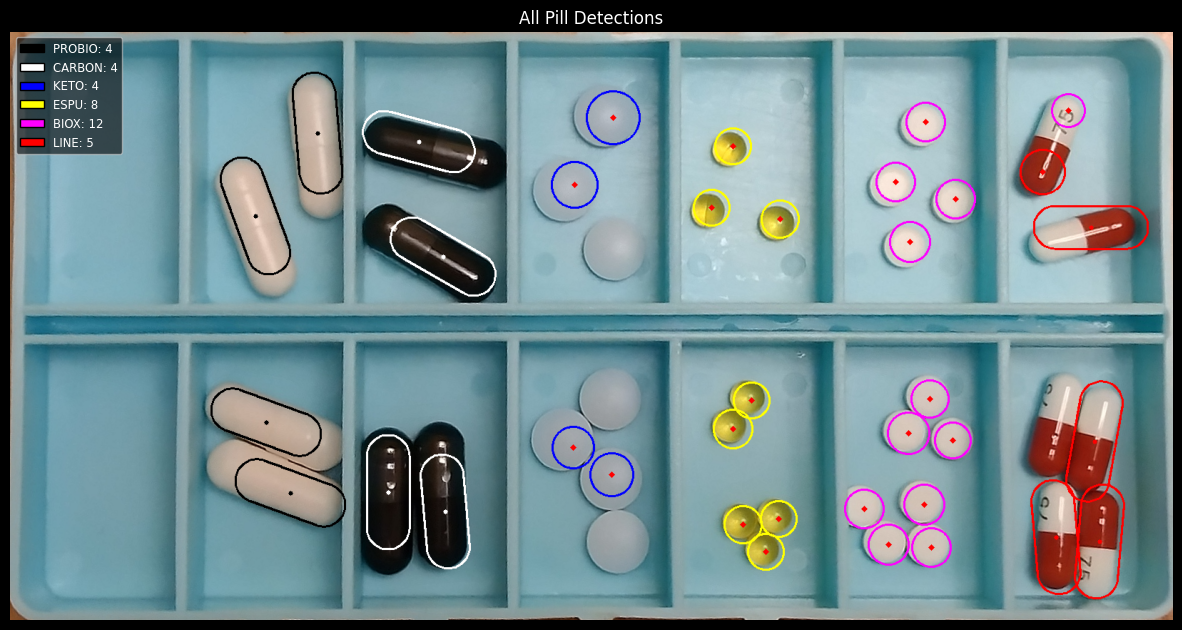

In [34]:
detections = detect_pills_in_pillbox(calib_cropped, debug=False)

Detected 14 compartments
Processing compartment 1


Detecting capsules:   0%|          | 0/108 [00:00<?, ?it/s]

Detecting capsules: 100%|██████████| 108/108 [00:00<00:00, 192.92it/s]


  Detected pills: {}

Processing compartment 2


Detecting capsules: 100%|██████████| 108/108 [00:02<00:00, 45.09it/s]


  Detected pills: {<PillType.CARBON: 2>: 1}

Processing compartment 3


Detecting capsules: 100%|██████████| 108/108 [00:02<00:00, 36.17it/s]


  Detected pills: {<PillType.CARBON: 2>: 1, <PillType.ESPU: 4>: 2}

Processing compartment 4


Detecting capsules: 100%|██████████| 108/108 [00:01<00:00, 57.71it/s]


  Detected pills: {<PillType.PROBIO: 1>: 1, <PillType.BIOX: 5>: 1}

Processing compartment 5


Detecting capsules: 100%|██████████| 108/108 [00:01<00:00, 67.94it/s]


  Detected pills: {<PillType.BIOX: 5>: 2, <PillType.ESPU: 4>: 2}

Processing compartment 6


Detecting capsules: 100%|██████████| 108/108 [00:02<00:00, 53.23it/s]


  Detected pills: {<PillType.PROBIO: 1>: 1, <PillType.BIOX: 5>: 1}

Processing compartment 7


Detecting capsules: 100%|██████████| 108/108 [00:03<00:00, 32.28it/s]


  Detected pills: {<PillType.CARBON: 2>: 1, <PillType.BIOX: 5>: 1}

Processing compartment 8


Detecting capsules: 100%|██████████| 108/108 [00:02<00:00, 36.79it/s]


  Detected pills: {<PillType.CARBON: 2>: 1}

Processing compartment 9


Detecting capsules: 100%|██████████| 108/108 [00:01<00:00, 80.98it/s]


  Detected pills: {<PillType.BIOX: 5>: 2}

Processing compartment 10


Detecting capsules: 100%|██████████| 108/108 [00:02<00:00, 53.47it/s]


  Detected pills: {<PillType.PROBIO: 1>: 1, <PillType.ESPU: 4>: 1}

Processing compartment 11


Detecting capsules: 100%|██████████| 108/108 [00:03<00:00, 30.41it/s]


  Detected pills: {<PillType.CARBON: 2>: 1}

Processing compartment 12


Detecting capsules: 100%|██████████| 108/108 [00:01<00:00, 74.62it/s]


  Detected pills: {<PillType.PROBIO: 1>: 1}

Processing compartment 13


Detecting capsules: 100%|██████████| 108/108 [00:00<00:00, 320.53it/s]


  Detected pills: {}

Processing compartment 14


Detecting capsules: 100%|██████████| 108/108 [00:03<00:00, 32.07it/s]


  Detected pills: {<PillType.CARBON: 2>: 1, <PillType.PROBIO: 1>: 1}



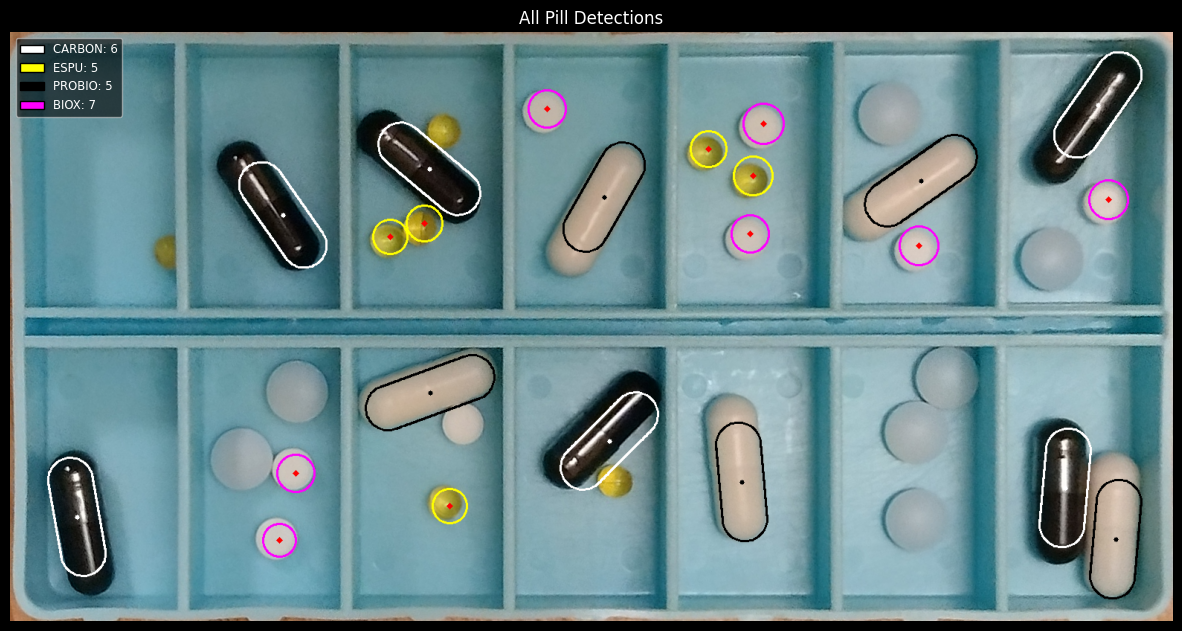

In [35]:
detections = detect_pills_in_pillbox(crop_image("dane5/test.png"))

Detected 14 compartments
Processing compartment 1


Detecting capsules: 100%|██████████| 108/108 [00:01<00:00, 77.92it/s]


  Detected pills: {<PillType.BIOX: 5>: 1, <PillType.LINE: 6>: 1}

Processing compartment 2


Detecting capsules: 100%|██████████| 108/108 [00:02<00:00, 45.06it/s]


  Detected pills: {<PillType.CARBON: 2>: 1}

Processing compartment 3


Detecting capsules: 100%|██████████| 108/108 [00:03<00:00, 32.31it/s]


  Detected pills: {<PillType.CARBON: 2>: 1, <PillType.ESPU: 4>: 2}

Processing compartment 4


Detecting capsules: 100%|██████████| 108/108 [00:02<00:00, 50.06it/s]


  Detected pills: {<PillType.PROBIO: 1>: 1, <PillType.BIOX: 5>: 1}

Processing compartment 5


Detecting capsules: 100%|██████████| 108/108 [00:02<00:00, 47.53it/s]


  Detected pills: {<PillType.BIOX: 5>: 2, <PillType.ESPU: 4>: 2}

Processing compartment 6


Detecting capsules: 100%|██████████| 108/108 [00:03<00:00, 34.04it/s]


  Detected pills: {<PillType.PROBIO: 1>: 1, <PillType.BIOX: 5>: 1, <PillType.KETO: 3>: 1}

Processing compartment 7


Detecting capsules: 100%|██████████| 108/108 [00:03<00:00, 28.20it/s]


  Detected pills: {<PillType.CARBON: 2>: 1, <PillType.BIOX: 5>: 1}

Processing compartment 8


Detecting capsules: 100%|██████████| 108/108 [00:04<00:00, 25.26it/s]


  Detected pills: {<PillType.CARBON: 2>: 1, <PillType.LINE: 6>: 1}

Processing compartment 9


Detecting capsules: 100%|██████████| 108/108 [00:02<00:00, 40.37it/s]


  Detected pills: {<PillType.BIOX: 5>: 2}

Processing compartment 10


Detecting capsules: 100%|██████████| 108/108 [00:01<00:00, 59.32it/s]


  Detected pills: {<PillType.PROBIO: 1>: 1, <PillType.ESPU: 4>: 1}

Processing compartment 11


Detecting capsules: 100%|██████████| 108/108 [00:03<00:00, 31.64it/s]


  Detected pills: {<PillType.CARBON: 2>: 1}

Processing compartment 12


Detecting capsules: 100%|██████████| 108/108 [00:01<00:00, 56.88it/s]


  Detected pills: {<PillType.PROBIO: 1>: 1}

Processing compartment 13


Detecting capsules: 100%|██████████| 108/108 [00:02<00:00, 52.61it/s]


  Detected pills: {<PillType.KETO: 3>: 1}

Processing compartment 14


Detecting capsules: 100%|██████████| 108/108 [00:02<00:00, 36.78it/s]


  Detected pills: {<PillType.PROBIO: 1>: 1}



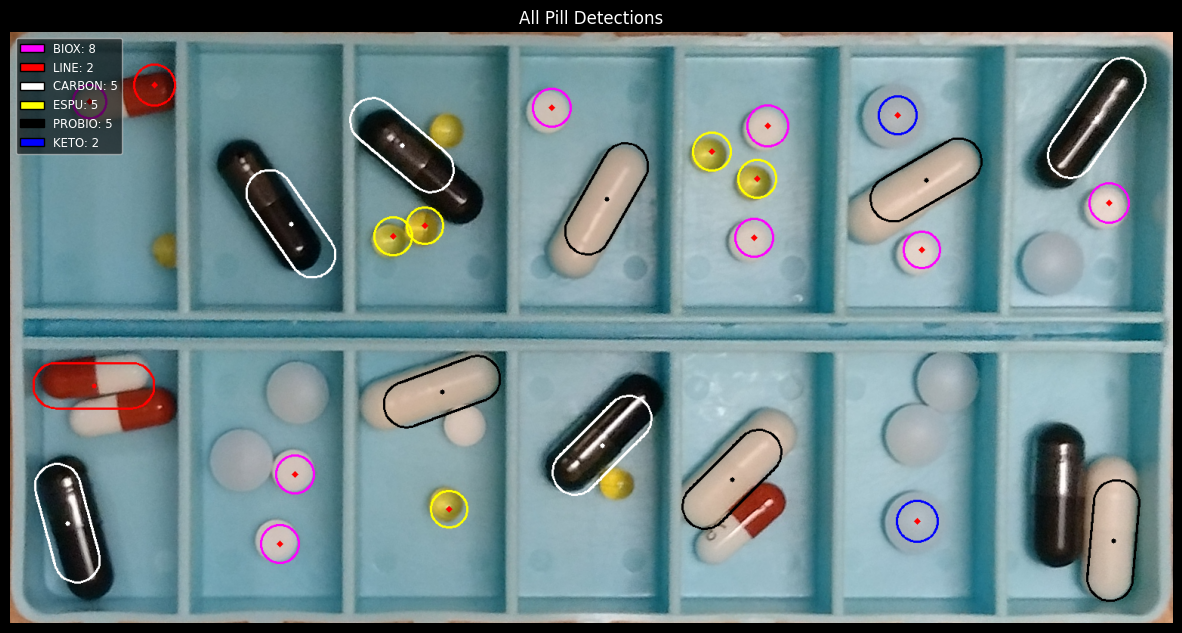

In [36]:
detections = detect_pills_in_pillbox(crop_image("dane5/test_line.png"))